# Setup SV model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload
import torch
import math
import time
import doobhtransform.core as doob
from doobhtransform.utils import normal_logpdf
from particlefilter.core import simulate_uncontrolled_SMC, simulate_controlled_SMC

In [3]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Computing on " + str(device))

Computing on cpu


In [4]:
# tuning parameters
d = 1 # dimension of latent state
std_obs = 1.0
theta = {}

# Latent process

In [5]:
# dict for objects relating to latent process
state = {}

# dimension of state
state["dim"] = d

# parameters of normal transition
alpha = torch.tensor(0.9, device=device)
beta = torch.tensor(0.0, device=device) 
xi_sq = torch.tensor(1.0, device=device)
xi = torch.sqrt(xi_sq)

# Ornstein-Uhlenbeck diffusion parameters
eta1 = -beta * torch.log(alpha) / (1.0 - alpha)
eta2 = -torch.log(alpha)
eta3 = torch.sqrt(-2.0 * torch.log(alpha) * xi_sq / (1.0 - alpha**2))

# drift and diffusivity of diffusion
b = lambda theta, x: eta1 - eta2 * x 
state["drift"] = b

# diffusion coefficient of diffusion
sigma = eta3
state["sigma"] = sigma

# simulate initial states (from stationary distribution)
rinit = lambda N: (eta1 / eta2) + (eta3 / torch.sqrt(2.0 * eta2)) * torch.randn(N, d, device=device)
# rinit = lambda N: torch.zeros(N, d)
state["rinit"] = rinit

# Observation model

In [6]:
# dict for objects relating to observations
obs = {}

# dimension of observation
p = d
obs["dim"] = p

# number of observations
T = 10
obs["num_obs"] = T

# observation time interval
interval = 1.0
obs["interval"] = interval

# observation parameters
var_obs = torch.tensor(std_obs**2, device=device)  # variance of observation

# log-observation density
obs_log_density = lambda theta, x, y: normal_logpdf(
    y, torch.zeros(1, p), var_obs * torch.exp(x)
)  # terminal condition, returns size (N)
obs["log_density"] = obs_log_density


# simulate observations
def observation(N):
    X = rinit(N)  # (N, d)
    Y = torch.zeros(N, T, p, device=device)
    for t in range(T):
        X = alpha * X + beta + xi * torch.randn(1, d, device=device)
        Y[:, t, :] = std_obs * torch.exp(0.5 * X) * torch.randn(1, p, device=device)        
    return Y
# observation = lambda N: rinit(N * T).reshape((N, T, d)) + std_obs * torch.randn(N, T, p, device=device)
obs["robs"] = observation

# # simulate observations
# def observation(N):
#     x = rinit(N * T).reshape((N, T, d))
#     y = std_obs * torch.exp(0.5 * x) * torch.randn(N, T, p, device=device)
#     return y
# obs["robs"] = observation

# Simulate states and observations

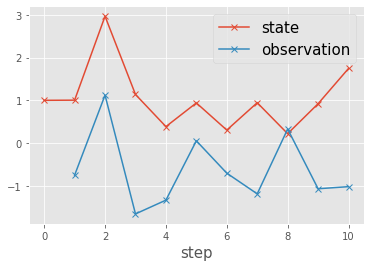

In [7]:
# simulate states and observations
X = torch.zeros(T + 1, d, device=device)
Y = torch.zeros(T, p, device=device)
for t in range(T):
    X[t + 1, :] = alpha * X[t, :] + beta + xi * torch.randn(1, d, device=device)
    Y[t, :] = std_obs * torch.exp(0.5 * X[t + 1, :]) * torch.randn(1, p, device=device)
X0 = X[0, ]
obs["sequence"] = Y

# # simulate observations
observation = lambda N: Y.repeat((N, 1, 1))
obs["robs"] = observation

# plot states and observations
plt.figure()
plt.plot(torch.arange(T + 1), torch.exp(X[:, 0]), "-x")
plt.plot(torch.arange(1, T + 1), Y[:, 0].cpu(), "-x")
plt.xlabel("step", fontsize=15)
plt.legend(["state", "observation"], fontsize=15)
plt.show()

# Train model

In [8]:
# algorithm settings
M = 20
num_steps = M
V_net_config = {"layers": [16], "full_obs": False}
Z_net_config = {"layers": [16], "full_obs": False
net_config = {"V": V_net_config, "Z": Z_net_config}
model = doob.model(state, obs, num_steps, net_config, device)

# optimization configuration
optim_config = {
    "minibatch": 100,
    "num_iterations": 1000,
    "learning_rate": 1e-2,
    "weight_decay": 0.0,
    "initial_required": True,
}

# training
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 3/1000 [00:00<01:39, 10.01it/s]

Optimization iteration: 1 Loss: 3422.859130859375


 10%|█         | 101/1000 [00:08<01:10, 12.72it/s]

Optimization iteration: 100 Loss: 2194.466552734375


 20%|██        | 201/1000 [00:16<01:04, 12.31it/s]

Optimization iteration: 200 Loss: 2936.179443359375


 30%|███       | 301/1000 [00:24<00:58, 11.97it/s]

Optimization iteration: 300 Loss: 7728.5947265625


 40%|████      | 401/1000 [00:33<00:50, 11.84it/s]

Optimization iteration: 400 Loss: 640.86865234375


 50%|█████     | 501/1000 [00:41<00:39, 12.52it/s]

Optimization iteration: 500 Loss: 2260.954833984375


 60%|██████    | 601/1000 [00:49<00:31, 12.71it/s]

Optimization iteration: 600 Loss: 4786.91552734375


 70%|███████   | 701/1000 [00:57<00:23, 12.66it/s]

Optimization iteration: 700 Loss: 778.3501586914062


 80%|████████  | 801/1000 [01:05<00:15, 12.79it/s]

Optimization iteration: 800 Loss: 633.7816162109375


 90%|█████████ | 901/1000 [01:13<00:07, 12.79it/s]

Optimization iteration: 900 Loss: 228417.953125


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]

Optimization iteration: 1000 Loss: 5561.92138671875
Training time (secs): 82.12647604942322


In [27]:
# more training
optim_config["initial_required"] = False
time_start = time.time()
model.train(theta, optim_config)
time_end = time.time()
time_elapsed = time_end - time_start
print("Training time (secs): " + str(time_elapsed))

  0%|          | 2/1000 [00:00<02:32,  6.55it/s]

Optimization iteration: 1 Loss: 80.41923522949219


 10%|█         | 101/1000 [00:15<02:32,  5.91it/s]

Optimization iteration: 100 Loss: 51.264835357666016


 20%|██        | 201/1000 [00:31<02:05,  6.36it/s]

Optimization iteration: 200 Loss: 74.99200439453125


 30%|███       | 301/1000 [00:47<01:48,  6.47it/s]

Optimization iteration: 300 Loss: 70.92396545410156


 40%|████      | 401/1000 [01:02<01:31,  6.55it/s]

Optimization iteration: 400 Loss: 43.212425231933594


 50%|█████     | 501/1000 [01:17<01:18,  6.35it/s]

Optimization iteration: 500 Loss: 1116.761474609375


 60%|██████    | 601/1000 [01:32<00:58,  6.86it/s]

Optimization iteration: 600 Loss: 247.10137939453125


 70%|███████   | 701/1000 [01:48<00:45,  6.57it/s]

Optimization iteration: 700 Loss: 259.9089660644531


 80%|████████  | 801/1000 [02:03<00:28,  6.90it/s]

Optimization iteration: 800 Loss: 143.07785034179688


 90%|█████████ | 901/1000 [02:17<00:14,  6.88it/s]

Optimization iteration: 900 Loss: 483.57501220703125


100%|██████████| 1000/1000 [02:32<00:00,  6.56it/s]

Optimization iteration: 1000 Loss: 1627.6573486328125
Training time (secs): 152.55578064918518


# Run SMC

In [9]:
N = 2**10

In [10]:
_states, _ess, _log_norm_const, _log_ratio_norm_const = (
    simulate_uncontrolled_SMC(model, theta, X0, Y, N, resample=True, full_path=True)
)
print("Log-likelihood estimate: " + str(float(_log_ratio_norm_const)))

Log-likelihood estimate: -16.995147705078125


In [11]:
states, ess, log_norm_const, log_ratio_norm_const = simulate_controlled_SMC(
    model, theta, X0, Y, N, resample=True, full_path=True
)
print("Log-likelihood estimate: " + str(float(log_ratio_norm_const)))

Log-likelihood estimate: -16.8978328704834


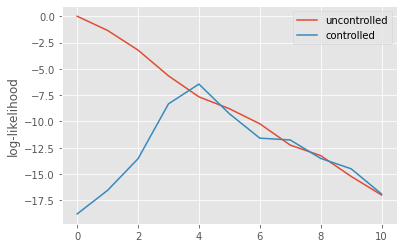

In [12]:
plt.figure()
plt.plot(_log_norm_const)
plt.plot(log_norm_const)
plt.ylabel("log-likelihood")
plt.legend(["uncontrolled", "controlled"])

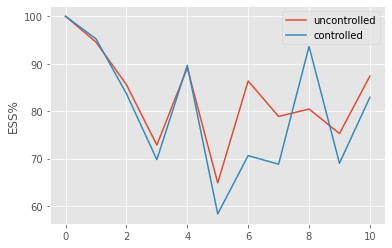

In [13]:
plt.figure()
plt.plot(_ess * 100 / N)
plt.plot(ess * 100 / N)
plt.ylabel("ESS%")
plt.legend(["uncontrolled", "controlled"])

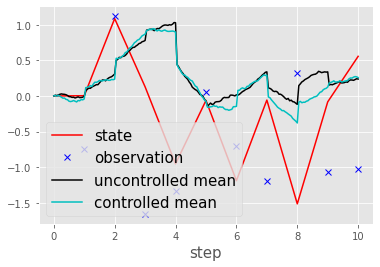

In [14]:
# plot states and observations (for full_path = False)
times = torch.linspace(0.0, T * interval, T * M + 1, device=device)
plt.figure()
plt.plot(torch.arange(T + 1), X[:, 0], "r-")
plt.plot(torch.arange(1, T + 1), Y[:, 0], "bx")
plt.plot(times, torch.mean(states[:, :, 0], 0), "k-")
plt.plot(times, torch.mean(_states[:, :, 0], 0), "c-")
# for n in range(N):
# plt.plot(times, states[n, :, 0], 'k.', alpha = 0.01)
plt.xlabel("step", fontsize=15)
plt.legend(
    ["state", "observation", "uncontrolled mean", "controlled mean"], fontsize=15
)
plt.show()